# Benchmarking RL methods to solve BlackJack


Thomas Lemercier & Gaspard Berthelier

## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/RL/blackjack

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/blackjack


In [2]:
import gym
import time
from tqdm import tqdm
import numpy as np

In [3]:
from src.utils.general import state_to_index, get_num_states, state_to_tensor_encoding
from src.utils.data_struct import Transition
from src.agents import Agent
from src.utils.visualization import plot_policy_simple_blackjack


def play_episode(env: gym.Env, agent: Agent, render: bool = False, array_encoding: bool = False):
    """plays one episode of given agent"""
    state = env.reset()
    if render:
        env.render()
    if array_encoding:
        state = state_to_tensor_encoding(state, env.observation_space)
    else:
        state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        if array_encoding:
            next_state = state_to_tensor_encoding(next_state, env.observation_space)
        else:
            next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int,  array_encoding: bool = False):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent, render= i == n_test_episodes-1, array_encoding=array_encoding) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
n_episodes = 500_000
n_test_episodes = 100_000

## Infinite Deck

Infinite deck, aka probabilities of drawing each card remains constant

In [6]:
from src.envs import InfiniteSimpleBlackjack

### Random

Random agent which takes action randomly at each step

In [ ]:
from src.agents import RandomAgent

env = InfiniteSimpleBlackjack(seed=42)
agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 9] (value: 19)
Dealer's hand: [10, 4] (value: 14)
Current state: [19 10  0]


Player's hand: [10, 9, 5] (value: 24)
Dealer's hand: [10, 4] (value: 14)
Current state: [24 10  0]

Win rate: 0.2785
Draw rate: 0.0419


### Monte Carlo

In [7]:
from src.agents import MonteCarloAgent

def main_monte_carlo(env: gym.Env, agent: MonteCarloAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        episode = agent.generate_episode(env)
        reward = episode[-1][2]
        agent.step(episode)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1
    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")
    print(f"\nTime taken: {time.time() - start:.2f} seconds")

100%|██████████| 500000/500000 [01:28<00:00, 5624.34it/s]


Win rate: 0.41
Draw rate: 0.09

Time taken: 88.91 seconds


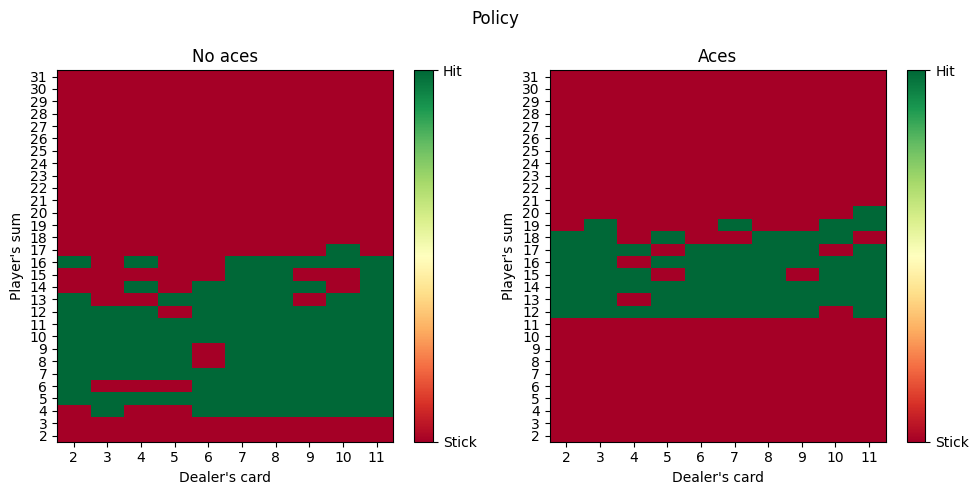

Win rate: 0.4149
Draw rate: 0.0873


In [11]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.visualization import plot_policy_simple_blackjack
from src.utils.data_struct import MonteCarloParameters

n_episodes = 500_000
env = InfiniteSimpleBlackjack(seed=42)
# exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 500000/500000 [00:52<00:00, 9515.75it/s]


Win rate: 0.34
Draw rate: 0.06

Time taken: 52.57 seconds


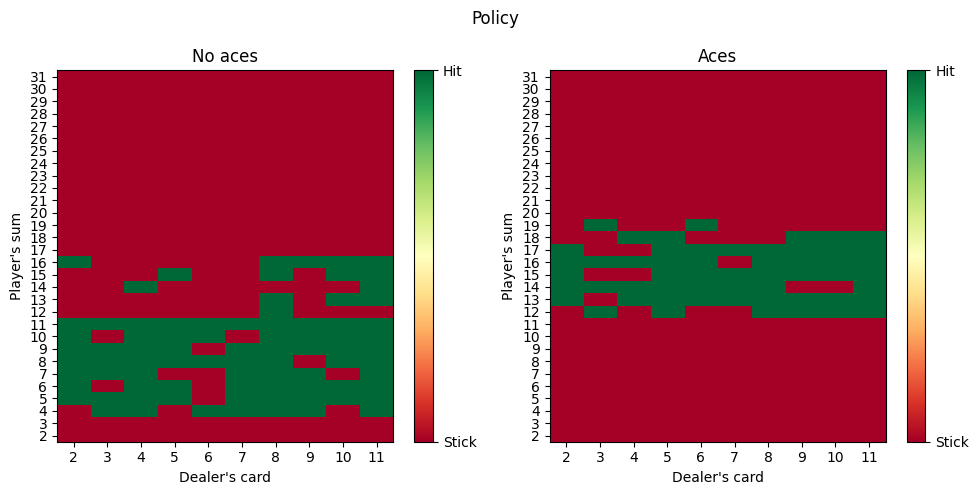

Win rate: 0.4111
Draw rate: 0.0762


In [10]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.visualization import plot_policy_simple_blackjack
from src.utils.data_struct import MonteCarloParameters

n_episodes = 500_000
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
#exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)


n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

### Sarsa

In [ ]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")

    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [ ]:
#ucb
env = InfiniteSimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [01:49<00:00, 4551.27it/s]


Win rate: 0.3606
Draw rate: 0.0773

Time taken: 109.8691 seconds


In [ ]:
#epsilon greedy 0.8
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.2
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

100%|██████████| 500000/500000 [00:47<00:00, 10615.71it/s]


Win rate: 0.3676
Draw rate: 0.0778

Time taken: 47.1095 seconds

Player's hand: [5, 4] (value: 9)
Dealer's hand: [2, 4] (value: 6)
Current state: [9 2 0]


Player's hand: [5, 4, 2] (value: 11)
Dealer's hand: [2, 4] (value: 6)
Current state: [11  2  0]


Player's hand: [5, 4, 2, 4] (value: 15)
Dealer's hand: [2, 4] (value: 6)
Current state: [15  2  0]


Player's hand: [5, 4, 2, 4, 10] (value: 25)
Dealer's hand: [2, 4] (value: 6)
Current state: [25  2  0]

Win rate: 0.3841
Draw rate: 0.0857


### Q Learning

In [ ]:
from src.agents import QlearningAgent
from src.utils.data_struct import QlearningParameters

def main_qlearning(env: gym.Env, agent: QlearningAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")
    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [ ]:
#ucb
env = InfiniteSimpleBlackjack(seed=42)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.8
env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.2

env = InfiniteSimpleBlackjack(seed=42)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

### DQN

In [17]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_index(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [18]:
n_episodes = 100_000

In [ ]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer
from src.explorations import EpsilonGreedy

params = DQNParameters()
env = InfiniteSimpleBlackjack(seed=42)

q_network = MLP(11, 64, env.action_space.n).to(params.device)
target_network = MLP(11, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)
agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

env = InfiniteSimpleBlackjack(seed=666)
play_policy(env, agent, n_test_episodes, array_encoding=True)

### DQN sequence

In [ ]:
from src.utils.general import state_to_tensor_sequence

def main(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

In [ ]:
params = DQNParameters()
q_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main(env, agent, n_episodes)

In [ ]:
n_test_episodes = 10000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

### DQN encoding

In [ ]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

In [ ]:
params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

In [ ]:
def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_encoding(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_encoding(next_state, env.observation_space)
        state = next_state
    return reward

In [ ]:
n_test_episodes = 10000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

### DQN embedding

In [ ]:
from src.networks import MLPEmbedding

input_range = env.observation_space["dealer"].high.item() - env.observation_space["dealer"].low.item() + 1

params = DQNParameters(device=torch.device("cpu"))
q_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

n_test_episodes = 10_000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

## Simple Finite

In [ ]:
from src.envs import SimpleBlackjack
env = SimpleBlackjack(seed=42, packs=4)

### Random

In [ ]:
agent = RandomAgent(env.action_space, seed=42)
play_policy(env, agent, n_test_episodes)


Player's hand: [11, 2] (value: 13)
Dealer's hand: [10, 7] (value: 17)
Current state: [13 10  1  2]


Player's hand: [11, 2, 9] (value: 12)
Dealer's hand: [10, 7] (value: 17)
Current state: [12 10  0  3]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: [17 10  0  4]

Win rate: 0.2791
Draw rate: 0.0414


### Monte Carlo

In [12]:
def main_monte_carlo(env: gym.Env, agent: MonteCarloAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        episode = agent.generate_episode(env)
        reward = episode[-1][2]
        agent.step(episode)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1
    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")
    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [ ]:
#UCB
n_episodes = 500_000
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

n_test_episodes = 10000
env = InfiniteSimpleBlackjack(seed=666)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [ ]:
n_episodes = 500_000
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
#exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
monte_carlo_parameters = MonteCarloParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = MonteCarloAgent(monte_carlo_parameters, exploration)

main_monte_carlo(env, agent, n_episodes)

policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)


n_test_episodes = 10000
env = SimpleBlackjack(seed=666, packs=4)
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

### Sarsa

In [ ]:
#ucb
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.8
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.2
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)
main_sarsa(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

### Q Learning

In [ ]:
#ucb
env = SimpleBlackjack(seed=42, packs=4)
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.8
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.8, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

In [ ]:
#epsilon greedy 0.2
env = SimpleBlackjack(seed=42, packs=4)
exploration = EpsilonGreedy(epsilon=0.2, decay=0.999999, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)
main_qlearning(env, agent, n_episodes)

env = SimpleBlackjack(seed=666, packs=4)
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)

## Complete

In [ ]:
from src.envs import Blackjack

### Random

In [ ]:
from src.agents import RandomAgent

env = Blackjack(seed=42, packs=4)
agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [11, 2] (value: 13)
Dealer's hand: [10, 7] (value: 17)
Current state: {'dealer': 10, 'player': [11, 2]}


Player's hand: [11, 2, 9] (value: 12)
Dealer's hand: [10, 7] (value: 17)
Current state: {'dealer': 10, 'player': [11, 2, 9]}


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: {'dealer': 10, 'player': [11, 2, 9, 5]}


Player's hand: [11, 2, 9, 5] (value: 17)
Dealer's hand: [10, 7] (value: 17)
Current state: {'dealer': 10, 'player': [11, 2, 9, 5]}

Win rate: 0.2782
Draw rate: 0.0420


### DQN

In [ ]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [ ]:
n_episodes = 100_000

In [ ]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

env = Blackjack(seed=42, packs=4)
params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 100000/100000 [06:41<00:00, 248.77it/s]

Win rate: 0.37
Draw rate: 0.05

Time taken: 401.99 seconds


In [ ]:
env = Blackjack(seed=666, packs=4)
play_policy(env, agent, n_test_episodes, array_encoding=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Player's hand: [10, 7] (value: 17)
Dealer's hand: [3, 9] (value: 12)
Current state: {'dealer': 3, 'player': [10, 7]}


Player's hand: [10, 7] (value: 17)
Dealer's hand: [3, 9, 5] (value: 17)
Current state: {'dealer': 3, 'player': [10, 7]}

Win rate: 0.3729
Draw rate: 0.0518


### DQN sequence

In [ ]:
from src.utils.general import state_to_tensor_sequence

def main(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

In [ ]:
params = DQNParameters()
env = Blackjack(seed=42, packs=4)
q_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network = MLP(1 + env.max_number_of_cards, 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main(env, agent, n_episodes)

100%|██████████| 100000/100000 [06:22<00:00, 261.70it/s]

Win rate: 0.37
Draw rate: 0.06

Time taken: 382.13 seconds


In [ ]:
n_test_episodes = 10000
env = Blackjack(seed=666, packs=4)

rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4186
Draw rate: 0.0660


### DQN encoding

In [ ]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

In [ ]:
params = DQNParameters()
env = Blackjack(seed=42, packs=4)

q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

100%|██████████| 500000/500000 [34:36<00:00, 240.76it/s]

Win rate: 0.36
Draw rate: 0.05

Time taken: 2076.73 seconds


In [ ]:
def play_episode(env: gym.Env, agent: DQN, render: bool = False):
    state = env.reset()
    if render:
        env.render()
    state = state_to_tensor_encoding(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        next_state = state_to_tensor_encoding(next_state, env.observation_space)
        state = next_state
    return reward

In [ ]:
n_test_episodes = 10000
env = Blackjack(seed=666, packs=4)

rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.3756
Draw rate: 0.0447


### DQN embedding

In [ ]:
from src.networks import MLPEmbedding
env = Blackjack(seed=42, packs=4)

input_range = env.observation_space["dealer"].high.item() - env.observation_space["dealer"].low.item() + 1

params = DQNParameters(device=torch.device("cpu"))
q_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network = MLPEmbedding(1, 64, env.action_space.n, input_range).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.8, 0.99)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

env = Blackjack(seed=666, packs=4)

n_test_episodes = 10_000
rewards = [play_episode(env, agent) for _ in range(n_test_episodes)]
n_wins = sum(reward == 1 for reward in rewards)
n_draws = sum(reward == 0 for reward in rewards)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

100%|██████████| 100000/100000 [07:01<00:00, 237.11it/s]


Win rate: 0.37
Draw rate: 0.05

Time taken: 421.76 seconds
Win rate: 0.3685
Draw rate: 0.0486
